<a href="https://colab.research.google.com/github/AAP9002/COMP34812-NLU-NLI/blob/main/NLU_Method_C/Transformer_Train_and_Evaluate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transformer based Approach for NLI

This notebook implements a pipeline for Natural Language Inference (NLI) using transformer-based models, with an additional ensemble learning approach for performance enhancement.

The main goal is to classify premise-hypothesis sentence pairs as either Support or Contradiction, using advanced transformer architectures and techniques to improve accuracy and generalization.
Key Components:

1. Data Loading & Exploration
- Loads dataset.
- Prepares train, development, and test splits.
- Explores class distribution and text statistics (word counts for premise and hypothesis).

2. Model 1: RoBERTa Large for NLI
- Fine-tunes the pre-trained RoBERTa-large model for binary classification.
- Freezes initial layers to speed up training.
- Evaluates on development and test sets.
- Visualizes training history and confusion matrices.
- Saves and loads model checkpoints for reproducibility.

3. Model 2: Semantic Textual Similarity Model
- Implements a sentence similarity model inspired by research (e.g., STS architectures).
- Utilizes separate encodings for premise and hypothesis.
- Applies mean pooling, dense layers, and classification head.
- Evaluates performance with visualizations.

4. Model 3: Ensemble Model
- Combines predictions from RoBERTa-large NLI model and the Semantic Similarity model.
- Concatenates logits from both models and applies dense layers for final prediction.
- Evaluates ensemble performance on all datasets.
- Visualizes training progress and saves final ensemble weights and architecture.

5. Model Comparison & Visualization
- Provides comparative analysis of the three models:
- Training, Development, and Test Accuracy
- Tabular summary and accuracy bar charts for better understanding of model performances.

Utilities:
- Confusion matrix plotting.
- Training history visualization.
- Helper functions for dataset preparation and tokenization.

# Ensemble Model Diagram

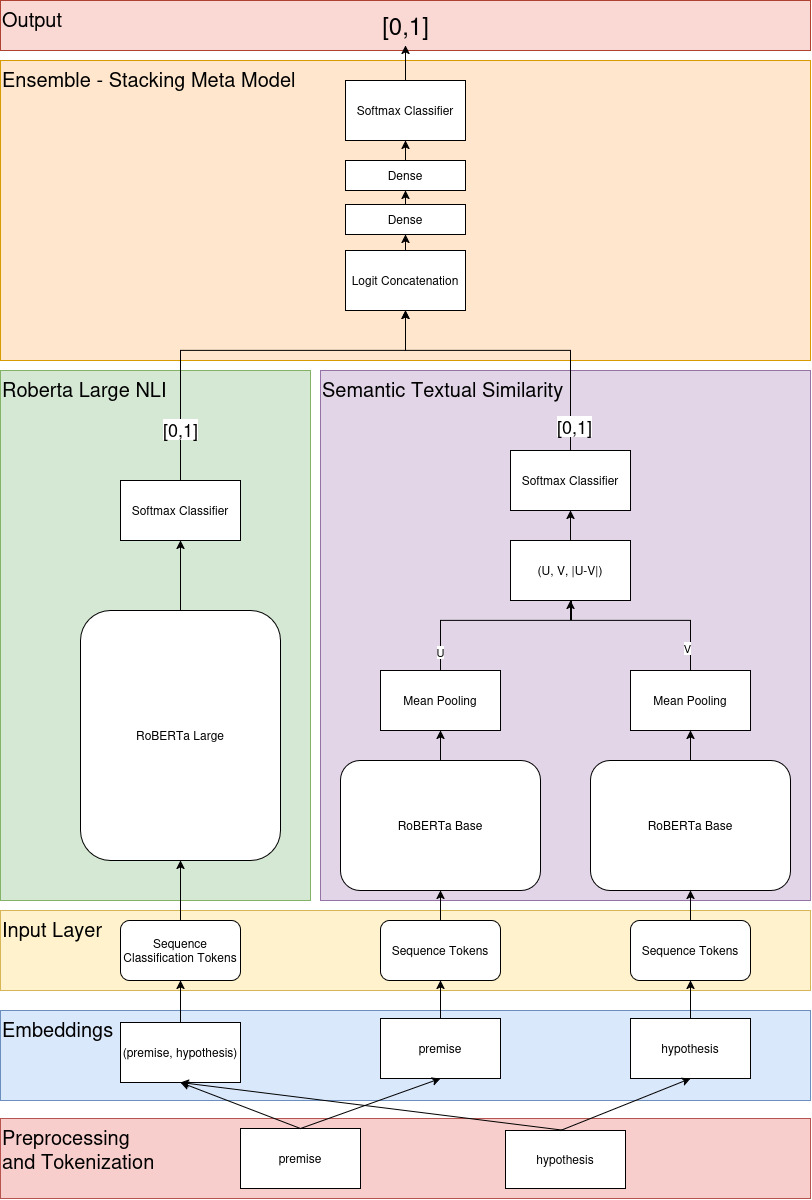

In [ ]:
RANDOM_STATE = 42
BATCH_SIZE = 16

FORCE_TRAIN_ALL = False

# Install packages

In [ ]:
!pip install pandas numpy tensorflow seaborn transformers huggingface_hub matplotlib scikit-learn --quiet

In [ ]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import transformers
from transformers import AutoTokenizer,TFAutoModel, TFRobertaForSequenceClassification
from huggingface_hub import snapshot_download

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import matplotlib.ticker as mtick

# Helper Functions

In [ ]:
def plot_history(history):
  # plot loss and accuracy for each epoch
  losses = history.history['loss']
  val_losses = history.history['val_loss']
  epochs = range(1, len(losses) + 1)

  try:
    accuracy = history.history['binary_accuracy']
    val_accuracy = history.history['val_binary_accuracy']
  except:
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

  plt.figure(figsize=(12, 4))

  plt.subplot(1, 2, 1)
  plt.plot(epochs, losses, 'r', label='Training loss')
  plt.plot(epochs, val_losses, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, 'r', label='Training accuracy')
  plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.show()

def plot_confussion(true, pred, title):
  # Plot confusion matrix
  cm = tf.math.confusion_matrix(true, pred)
  cm = cm.numpy()
  cm = cm / cm.sum(axis=1, keepdims=True)
  plt.figure(figsize=(8, 6))

  sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues')
  plt.title(title)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.show()

  return cm

# Load Dataset and Checkpoint Models

In [ ]:
# set HF_TOKEN in your enviroment

# load datasets
snapshot_download(repo_id="aap9002/NLU-Coursework",  repo_type="dataset", allow_patterns=f"*", local_dir='./')

if not FORCE_TRAIN_ALL:
  # load model weights
  snapshot_download(repo_id="aap9002/NLI-Transformer-Ensemble-Model", allow_patterns=f"*", local_dir='./')

In [ ]:
def get_split_datasets():
  dev_set = pd.read_csv('dev.csv')
  train_set = pd.read_csv('train.csv')

  # create a test set out of validation if no test.csv exists
  try:
      test_set = pd.read_csv('test.csv')
  except:
      test_set = dev_set.sample(frac=0.2, random_state=RANDOM_STATE) # random state set for reproducability
      dev_set = dev_set.drop(test_set.index)

      test_set.reset_index()
      dev_set.reset_index()

  return train_set, dev_set, test_set

train_set, dev_set, test_set = get_split_datasets()

In [ ]:
print(f"train set shape:{train_set.shape}")
train_set.head()

In [ ]:
print(f"dev set shape:{dev_set.shape}")
dev_set.head()

In [ ]:
print(f"test set shape:{test_set.shape}")
test_set.head()

remove records with invalid labels

In [ ]:
train_set = train_set.dropna(subset=['label'])
dev_set = dev_set.dropna(subset=['label'])
test_set = test_set.dropna(subset=['label'])

## Explore dataset

class balence
- Our dataset is labelled with a 0 or 1 to indicate a supporting or contradicting permissive hypothesis pair

In [ ]:
def get_class_balance(train_set, dev_set, test_set):
  label_map = {
      0: 'Contradiction',
      1: 'Support'
  }

  # count class instances
  labels_counts = [train_set['label'].value_counts(), dev_set['label'].value_counts(), test_set['label'].value_counts()]
  labels_counts = pd.concat(labels_counts, axis=1)
  labels_counts.columns = ['train', 'dev', 'test']

  # set label names
  labels_counts.index = labels_counts.index.map(label_map)

  # plot bar chart
  labels_counts.plot(kind="bar", stacked=True, title="Distribution of Classes", xlabel="Class", ylabel="Count")
  plt.show()

  return labels_counts

labels_counts = get_class_balance(train_set, dev_set, test_set)

Average word counts of premise and hypothosis

In [ ]:
# collate all premise and hypothesis
premise_counts = [train_set['premise'].str.split().str.len(), dev_set['premise'].str.split().str.len(), test_set['premise'].str.split().str.len()]
hypothesis_counts = [train_set['hypothesis'].str.split().str.len(), dev_set['hypothesis'].str.split().str.len(), test_set['hypothesis'].str.split().str.len()]

premise_counts = pd.concat(premise_counts, axis=1)
hypothesis_counts = pd.concat(hypothesis_counts, axis=1)

premise_counts.columns = ['train', 'dev', 'test']
hypothesis_counts.columns = ['train', 'dev', 'test']

# use describe to output statistics
print(f"Premise:\n{premise_counts.describe()}\n")
print(f"Hypothesis:\n{hypothesis_counts.describe()}\n")

# RoBERTa NLI Binary Classification Model
Fine tuning a RoBERTa Large model to be used as a component of the ensemble model.

In [ ]:
# get tokenizer
roberta_large_tokenizer = AutoTokenizer.from_pretrained("FacebookAI/roberta-large")

### Data preparation

In [ ]:
train_set

Get dataset embeddings

In [ ]:
def token_sequence(pairs, labels):
  premises = [premise for premise, hypo in pairs.values]
  hypotheses = [hypo for premise, hypo in pairs.values]

  # tokenize
  encodings = roberta_large_tokenizer(
      premises,
      hypotheses,
      padding=True,
      truncation=True,
      return_tensors="tf"
  )

  labels = tf.one_hot(labels, depth=2) # comment if we wish to use multi-class
  dataset = tf.data.Dataset.from_tensor_slices((dict(encodings), labels))
  return dataset

# get embedding for each dataset
train_embeddings = token_sequence(train_set[['premise', 'hypothesis']], train_set['label'])
dev_embeddings = token_sequence(dev_set[['premise', 'hypothesis']], dev_set['label'])
test_embeddings = token_sequence(test_set[['premise', 'hypothesis']], test_set['label'])

In [ ]:
# prepare dataset into batches
train_batches_roberta_large_nli = train_embeddings.batch(BATCH_SIZE)
dev_batches_roberta_large_nli = dev_embeddings.batch(BATCH_SIZE)
test_batches_roberta_large_nli = test_embeddings.batch(BATCH_SIZE)

## Fine-Tune RoBERTa Binary Classification Model

In [ ]:
# load RoBERTa large base model
roberta_large_model = TFRobertaForSequenceClassification.from_pretrained(
    "FacebookAI/roberta-large",
    num_labels=2,
    )

# freeze layer for performance and retain early learned layers
N = 6  # Number of layers to freeze
for layer in roberta_large_model.roberta.encoder.layer[:N]:
    layer.trainable = False
print(f"Freezing first {N} layers of {len(roberta_large_model.roberta.encoder.layer)} roberta")

roberta_large_model.summary()

Compile model for training

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = [tf.keras.metrics.BinaryAccuracy(name='binary_accuracy', threshold=0.5)]

roberta_large_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

Train Model

In [ ]:
if os.path.exists('nli_large_roberta_model.h5'): # if model checkpoint exists
    roberta_large_model.load_weights('nli_large_roberta_model.h5') # load checkpoint model
    print("Model was loaded from weights")
else:
  # train model
  history = roberta_large_model.fit(train_batches_roberta_large_nli, validation_data=dev_batches_roberta_large_nli , epochs=5)
  plot_history(history)

## Evaluate Model

Evaluate on dev set

In [ ]:
loss, accuracy = roberta_large_model.evaluate(dev_batches_roberta_large_nli)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

Get performance on dev set

In [ ]:
predictions = roberta_large_model.predict(dev_batches_roberta_large_nli)
prediction_labels = predictions.logits.argmax(axis=-1)

print(classification_report(dev_set['label'], prediction_labels))
plot_confussion(dev_set['label'], prediction_labels, "Confusion Matrix on Dev Set")

Get performance on test set

In [ ]:
predictions = roberta_large_model.predict(test_batches_roberta_large_nli)
prediction_labels = predictions.logits.argmax(axis=-1)

print(classification_report(test_set['label'], prediction_labels))
plot_confussion(test_set['label'], prediction_labels, "Confusion Matrix on Test Set")

### Save model checkpoints

Save checkpoint model for future runs

In [ ]:
if not os.path.exists('nli_large_roberta_model.h5'):
  roberta_large_model.save_weights('nli_large_roberta_model.h5')
  print("Saved model weights to file")

# Semantic Textual Similarity (STS) Model

Archetecture based on:https://arxiv.org/pdf/1908.10084

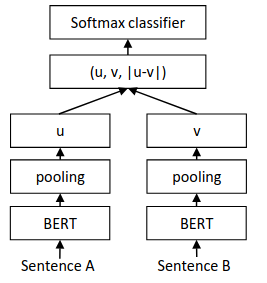
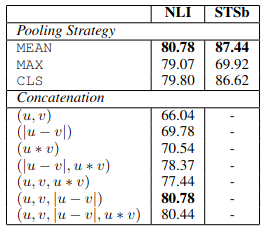



Load Base Model

In [ ]:
model_name = 'FacebookAI/roberta-base'
roberta_base_tokenizer = AutoTokenizer.from_pretrained(model_name)

## Data Preparation

In [ ]:
def create_sequence_simularity_dataset(df, tokenizer=roberta_base_tokenizer, batch_size=32):
    """
    Creates a tf.data.Dataset for sentence pair inputs with separate tokenization.

    Args:
        df (pandas.DataFrame): Must contain 'premise', 'hypothesis', and 'label' columns.
        tokenizer (transformers.PreTrainedTokenizer): HuggingFace tokenizer.
        batch_size (int): Batch size for dataset.

    Returns:
        tf.data.Dataset: A batched and tokenized dataset with separate inputs.
    """
    sentences_a = df['premise'].tolist()
    sentences_b = df['hypothesis'].tolist()
    labels = df['label'].tolist()

    # Tokenize each set of sentences separately
    inputs_a = tokenizer(
        sentences_a,
        padding=True,
        truncation=True,
        return_tensors='np'
    )

    inputs_b = tokenizer(
        sentences_b,
        padding=True,
        truncation=True,
        return_tensors='np'
    )

    # Create a dataset with separate inputs for sentence A and sentence B
    dataset = tf.data.Dataset.from_tensor_slices((
        {
            'input_ids_a': inputs_a['input_ids'],
            'attention_mask_a': inputs_a['attention_mask'],
            'input_ids_b': inputs_b['input_ids'],
            'attention_mask_b': inputs_b['attention_mask']
        },
        tf.one_hot(labels, depth=2)  # For binary classification (adjust depth for multi-class)
    ))

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

# prepare embedding inputs to model
train_batches_simularity = create_sequence_simularity_dataset(train_set, roberta_base_tokenizer, batch_size=32)
dev_batches_simularity = create_sequence_simularity_dataset(dev_set, roberta_base_tokenizer, batch_size=32)
test_batches_simularity = create_sequence_simularity_dataset(test_set, roberta_base_tokenizer, batch_size=32)

## Fine-Tune Semantic Textual Similarity Binary Classification Model






This arctecture was chosen with a classification objective.

In [ ]:
def build_sentence_pair_model(model_name='FacebookAI/roberta-base', num_classes=2):
    """
    Builds a sentence pair classification model using FacebookAI/roberta-base.

    Args:
        model_name: Name of the pre-trained FacebookAI/roberta-base model.
        pooling_strategy: Pooling strategy ('mean' or 'cls').
        num_classes: Number of output classes for classification.

    Returns:
        A TensorFlow Keras model.
    """

    # Load BERT model and tokenizer
    roberta_model = TFAutoModel.from_pretrained(model_name)

    N = 6  # Number of layers to freeze
    for layer in roberta_model.roberta.encoder.layer[:N]:
        layer.trainable = False
    print(f"Freezing first {N} layers of {len(roberta_model.roberta.encoder.layer)} roberta")


    # Input layers for Sentence A and Sentence B
    input_ids_a = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='input_ids_a')
    attention_mask_a = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='attention_mask_a')

    input_ids_b = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='input_ids_b')
    attention_mask_b = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='attention_mask_b')

    # BERT embeddings for Sentence A
    outputs_a = roberta_model(input_ids_a, attention_mask=attention_mask_a)
    last_hidden_state_a = outputs_a.last_hidden_state

    # BERT embeddings for Sentence B
    outputs_b = roberta_model(input_ids_b, attention_mask=attention_mask_b)
    last_hidden_state_b = outputs_b.last_hidden_state

    # Pooling layer - Mean pooling
    input_mask_expanded_a = tf.cast(tf.expand_dims(attention_mask_a, axis=-1), tf.float32)
    sum_embeddings_a = tf.reduce_sum(last_hidden_state_a * input_mask_expanded_a, axis=1)
    sum_mask_a = tf.reduce_sum(input_mask_expanded_a, axis=1)
    u = sum_embeddings_a / tf.clip_by_value(sum_mask_a, 1e-9, tf.reduce_max(sum_mask_a))

    input_mask_expanded_b = tf.cast(tf.expand_dims(attention_mask_b, axis=-1), tf.float32)
    sum_embeddings_b = tf.reduce_sum(last_hidden_state_b * input_mask_expanded_b, axis=1)
    sum_mask_b = tf.reduce_sum(input_mask_expanded_b, axis=1)
    v = sum_embeddings_b / tf.clip_by_value(sum_mask_b, 1e-9, tf.reduce_max(sum_mask_b))

    # Concatenate u, v, and |u-v|
    concat_layer = tf.keras.layers.Concatenate()([u, v, tf.abs(u - v)])

    x = tf.keras.layers.Dense(256, activation='relu')(concat_layer)
    x = tf.keras.layers.Dropout(0.4)(x)

    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    x = tf.keras.layers.Dense(64, activation='relu')(x)

    # Softmax classifier
    output = tf.keras.layers.Dense(num_classes)(x)

    # Build the model
    model = tf.keras.Model(inputs=[input_ids_a, attention_mask_a,
                                  input_ids_b, attention_mask_b],
                           outputs=output,
                           name="semantic_textual_similarity_model")

    return model

# Example Usage
similarity_model = build_sentence_pair_model(num_classes=2)
similarity_model.summary()

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
metrics = ['accuracy']

similarity_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)


In [ ]:
if os.path.exists('similarity_model.h5'): # load checkpoint model if exists
  similarity_model.load_weights('similarity_model.h5')
  print("Loaded model weights from file")
else:
  # train model
  history = similarity_model.fit(train_batches_simularity, validation_data=dev_batches_simularity , epochs=5)
  plot_history(history)

## Evaluate Sentence Simularity Model

evaluate performance on dev set

In [ ]:
loss, accuracy = similarity_model.evaluate(dev_batches_simularity)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

In [ ]:
predictions = similarity_model.predict(dev_batches_simularity)
prediction_labels = predictions.argmax(axis=-1)

print(classification_report(dev_set['label'], prediction_labels))
plot_confussion(dev_set['label'], prediction_labels, "Confusion Matrix on Dev Set")

evaluate performance on test set

In [ ]:
predictions = similarity_model.predict(test_batches_simularity)
prediction_labels = predictions.argmax(axis=-1)
print(classification_report(test_set['label'], prediction_labels))
plot_confussion(test_set['label'], prediction_labels, "Confusion Matrix on Test Set")

### Save Model Checkpoints

In [ ]:
if not os.path.exists('similarity_model.h5'): # save checkpoint model for future runs
  similarity_model.save_weights('similarity_model.h5')
  print("Saved model weights to file")

# Ensamble Learning

Combine the NLI Binary Classification and Semantic Textual Similarity (STS) model for binary Classification

In [ ]:
ENSAMBLE_TRAIN_BATCH_SIZE = 128

## Data Preparation

In [ ]:
def create_ensemble_dataset(df, nli_tokenizer, sim_tokenizer, batch_size=16):
  """
    Creates a tf.data.Dataset for out ensamble model.

    Args:
        df (pandas.DataFrame): Must contain 'premise', 'hypothesis', and 'label' columns.
        nli_tokenizer (transformers.PreTrainedTokenizer): HuggingFace tokenizer for RoBERTa Large NLI Model
        sim_tokenizer (transformers.PreTrainedTokenizer): HuggingFace tokenizer for Similarity Model
        batch_size (int): Batch size for dataset.

    Returns:
        tf.data.Dataset: A batched and tokenized dataset with separate inputs.
    """
  premises = df['premise'].tolist()
  hypotheses = df['hypothesis'].tolist()
  labels = df['label'].tolist()

  inputs_nli = roberta_large_tokenizer(
      premises,
      hypotheses,
      padding=True,
      truncation=True,
      return_tensors="tf"
  )

  # Tokenize each set of sentences separately
  inputs_a = sim_tokenizer(
        premises,
        padding=True,
        truncation=True,
        return_tensors='np'
  )

  inputs_b = sim_tokenizer(
        hypotheses,
        padding=True,
        truncation=True,
        return_tensors='np'
  )

  dataset = tf.data.Dataset.from_tensor_slices((
        {
            'input_ids_nli': inputs_nli['input_ids'],
            'attention_mask_nli': inputs_nli['attention_mask'],
            'input_ids_a': inputs_a['input_ids'],
            'attention_mask_a': inputs_a['attention_mask'],
            'input_ids_b': inputs_b['input_ids'],
            'attention_mask_b': inputs_b['attention_mask']
        },
        tf.one_hot(labels, depth=2)  # For binary classification (adjust depth for multi-class)
  ))
  dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(tf.data.AUTOTUNE)

  return dataset

# prepare dataset embeddings to input
train_ensemble_dataset = create_ensemble_dataset(train_set, roberta_large_tokenizer, roberta_base_tokenizer, batch_size = ENSAMBLE_TRAIN_BATCH_SIZE)
dev_ensemble_dataset = create_ensemble_dataset(dev_set, roberta_large_tokenizer, roberta_base_tokenizer)
test_ensemble_dataset = create_ensemble_dataset(test_set, roberta_large_tokenizer, roberta_base_tokenizer)

## Build Ensemble Model

In [ ]:
def build_ensemble_model():
    """
    Builds an ensemble model for binary classification, which incoperates:
    - RoBERTa Large NLI Model
    - Semantic Textual Similarity Model

    Returns:
        A TensorFlow Keras model.
    """

    # prevent further finetuning
    roberta_large_model.trainable = False
    similarity_model.trainable = False

    # Define inputs for the NLI branch
    input_ids_nli = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='input_ids_nli')
    attention_mask_nli = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='attention_mask_nli')

    # Define inputs for the similarity branch (sentence pair inputs)
    input_ids_a = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='input_ids_a')
    attention_mask_a = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='attention_mask_a')
    input_ids_b = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='input_ids_b')
    attention_mask_b = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='attention_mask_b')

    # get logits
    nli_output = roberta_large_model(input_ids_nli, attention_mask=attention_mask_nli).logits
    sim_output = similarity_model([input_ids_a, attention_mask_a, input_ids_b, attention_mask_b])

    # Concatenate logits
    combined = tf.keras.layers.Concatenate()([nli_output, sim_output])  # shape (batch, 4)

    # Small dense layers to learn interactions
    hidden = tf.keras.layers.Dense(16, activation='relu')(combined)
    output = tf.keras.layers.Dense(2, activation='softmax')(hidden)

    # Build the ensemble model
    ensemble_model = tf.keras.Model(
        inputs=[input_ids_nli, attention_mask_nli, input_ids_a, attention_mask_a, input_ids_b, attention_mask_b],
        outputs=output
    )
    return ensemble_model

# Instantiate the ensemble model
ensemble_model = build_ensemble_model()
ensemble_model.summary()


Prepare model for training

In [ ]:
ensemble_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
if os.path.exists('ensamble_model.h5'): # load model if checkpoint model exists
  ensemble_model.load_weights('ensamble_model.h5')
  print("Loaded model weights from file")
else:
  # train ensamble model
  history = ensemble_model.fit(train_ensemble_dataset, validation_data=dev_ensemble_dataset , epochs=3)
  plot_history(history)

## Evaluate Ensemble Model

evaluate ensamble on dev set

In [ ]:
loss, accuracy = ensemble_model.evaluate(dev_ensemble_dataset)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

In [ ]:
predictions = ensemble_model.predict(dev_ensemble_dataset)
prediction_labels = predictions.argmax(axis=-1)

print(classification_report(dev_set['label'], prediction_labels))
plot_confussion(dev_set['label'], prediction_labels, "Confusion Matrix on Dev Set")

evaluate ensemble on test set



In [ ]:
predictions = ensemble_model.predict(test_ensemble_dataset)
prediction_labels = predictions.argmax(axis=-1)
print(classification_report(test_set['label'], prediction_labels))
plot_confussion(test_set['label'], prediction_labels, "Confusion Matrix on Test Set")

In [ ]:
if not os.path.exists('ensamble_model.h5'): # save model checkpoint for future runs
  ensemble_model.save_weights('ensamble_model.h5')
  print("Saved model weights to file")

# Save final model with architecture and weights

Output our final model to be used in the demo script

Include trained weights and architecture

In [ ]:
ensemble_model.save("ensamble_model_weights_and_arch.h5", save_format='h5')

# Plot Model Comparasion of Accuracy On Sets

In [ ]:
def plot_model_comparison():
  # Model names
  models = ['RoBERTa Large', 'Similarity Model', 'Ensemble Model']

  train_acc = [eval_result[1] for eval_result in train_eval] # Extract accuracy from train_eval
  dev_acc = [eval_result[1] for eval_result in dev_eval]     # Extract accuracy from dev_eval
  test_acc = [eval_result[1] for eval_result in test_eval]    # Extract accuracy from test_eval

  # X locations for the groups
  x = np.arange(len(models))
  width = 0.25  # width of the bars

   # Create the plot
  plt.figure(figsize=(8, 5))
  plt.bar(x - width, train_acc, width, label='Train') # Use train_acc for bar heights
  plt.bar(x, dev_acc, width, label='Dev')           # Use dev_acc for bar heights
  plt.bar(x + width, test_acc, width, label='Test')      # Use test_acc for bar heights

  # Labels and formatting
  plt.title('Transformer Based Model Accuracy Comparison')
  plt.xlabel('Models')
  plt.ylabel('Accuracy')
  plt.ylim(0, 1)
  plt.xticks(x, models)
  plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))  # Show percentages
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
  plt.grid(axis='y', linestyle='--', alpha=0.7)
  plt.tight_layout()

  plt.show()

In [ ]:
def model_comparison_table():
    # Model names
    models = ['RoBERTa Large', 'Similarity Model', 'Ensemble Model']

    # Extract accuracy values from evaluation results
    train_acc = [eval_result[1] for eval_result in train_eval]
    dev_acc = [eval_result[1] for eval_result in dev_eval]
    test_acc = [eval_result[1] for eval_result in test_eval]

    # Create a Pandas DataFrame
    data = {
        'Model': models,
        'Train Accuracy': train_acc,
        'Dev Accuracy': dev_acc,
        'Test Accuracy': test_acc
    }
    df = pd.DataFrame(data)

    # Format accuracy values as percentages
    df['Train Accuracy'] = df['Train Accuracy'].map('{:.2%}'.format)
    df['Dev Accuracy'] = df['Dev Accuracy'].map('{:.2%}'.format)
    df['Test Accuracy'] = df['Test Accuracy'].map('{:.2%}'.format)

    display(df)

In [ ]:
train_eval = [roberta_large_model.evaluate(train_batches_roberta_large_nli), similarity_model.evaluate(train_batches_simularity), ensemble_model.evaluate(train_ensemble_dataset)]
dev_eval = [roberta_large_model.evaluate(dev_batches_roberta_large_nli), similarity_model.evaluate(dev_batches_simularity), ensemble_model.evaluate(dev_ensemble_dataset)]
test_eval = [roberta_large_model.evaluate(test_batches_roberta_large_nli), similarity_model.evaluate(test_batches_simularity), ensemble_model.evaluate(test_ensemble_dataset)]

model_comparison_table()
plot_model_comparison()